#AUTHORS


*   İbrahim Güldemir ibrahimguldemir123@gmail.com
*   Süleyman Samet Kaya suleymansametkaya@gmail.com



# Gerekli Kütüphanelerin İçe Aktarılması

In [103]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

# Bu hücrede, CNN modelini oluşturmak ve eğitmek için gerekli olan kütüphaneler içe aktarılmaktadır.


# Veri Setinin Yüklenmesi ve Ön İşleme

In [104]:
# CIFAR-10 veri setini yükleme
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()

# Veri seti bilgilerini yazdırma
print(f"Training data shape: {x_train.shape}")
print(f"Testing data shape: {x_test.shape}")
print(f"Number of training samples: {x_train.shape[0]}")
print(f"Number of testing samples: {x_test.shape[0]}")
print(f"Image dimensions: {x_train.shape[1:]}")

# Verileri normalize etme
x_train = x_train.astype("float32") / 255.0
x_test = x_test.astype("float32") / 255.0

# Veri artırma
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.1),
    ]
)


# Bu hücrede, CIFAR-10 veri seti yüklenir, veri seti bilgileri yazdırılır ve piksel değerleri 0-255 aralığından 0-1 aralığına normalize edilir.


Training data shape: (50000, 32, 32, 3)
Testing data shape: (10000, 32, 32, 3)
Number of training samples: 50000
Number of testing samples: 10000
Image dimensions: (32, 32, 3)


# Bazı Resimlerin Görselleştirilmesi

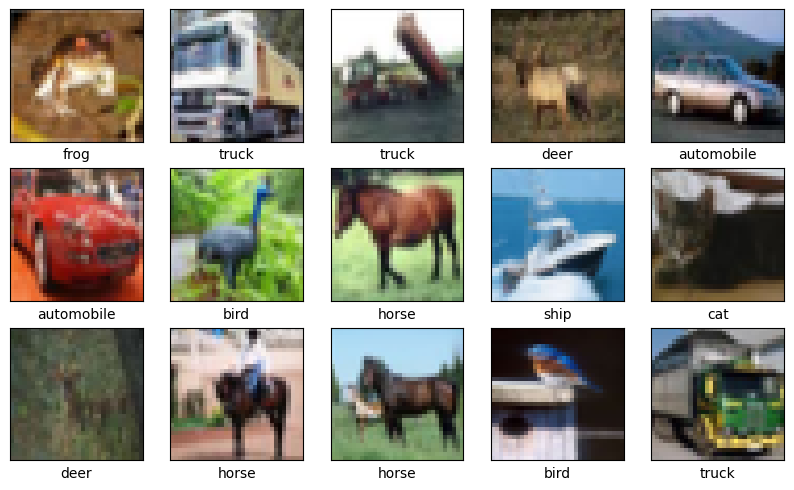

In [105]:
# Sınıf isimleri
class_names = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]

# 10-15 resim gösterme
num_images_to_show = 15
plt.figure(figsize=(10, 10))
for i in range(num_images_to_show):
    plt.subplot(5, 5, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_train[i])
    plt.xlabel(class_names[y_train[i][0]])
plt.show()

# Bu hücrede, eğitim setinden 15 resim gösterilir ve her bir resim altına sınıf ismi eklenir.


# Involution Katmanının Tanımlanması

In [106]:
class Involution(keras.layers.Layer):
    def __init__(self, channel, group_number, kernel_size, stride, reduction_ratio, name):
        super().__init__(name=name)
        self.channel = channel
        self.group_number = group_number
        self.kernel_size = kernel_size
        self.stride = stride
        self.reduction_ratio = reduction_ratio

    def build(self, input_shape):
        (_, height, width, num_channels) = input_shape
        height = height // self.stride
        width = width // self.stride

        self.stride_layer = (
            keras.layers.AveragePooling2D(
                pool_size=self.stride, strides=self.stride, padding="same"
            )
            if self.stride > 1
            else tf.identity
        )
        self.kernel_gen = keras.Sequential(
            [
                keras.layers.Conv2D(
                    filters=self.channel // self.reduction_ratio, kernel_size=1
                ),
                keras.layers.BatchNormalization(),
                keras.layers.ReLU(),
                keras.layers.Conv2D(
                    filters=self.kernel_size * self.kernel_size * self.group_number,
                    kernel_size=1,
                ),
            ]
        )
        self.kernel_reshape = keras.layers.Reshape(
            target_shape=(
                height,
                width,
                self.kernel_size * self.kernel_size,
                1,
                self.group_number,
            )
        )
        self.input_patches_reshape = keras.layers.Reshape(
            target_shape=(
                height,
                width,
                self.kernel_size * self.kernel_size,
                num_channels // self.group_number,
                self.group_number,
            )
        )
        self.output_reshape = keras.layers.Reshape(
            target_shape=(height, width, num_channels)
        )

    def call(self, x):
        kernel_input = self.stride_layer(x)
        kernel = self.kernel_gen(kernel_input)
        kernel = self.kernel_reshape(kernel)
        input_patches = tf.image.extract_patches(
            images=x,
            sizes=[1, self.kernel_size, self.kernel_size, 1],
            strides=[1, self.stride, self.stride, 1],
            rates=[1, 1, 1, 1],
            padding="SAME",
        )
        input_patches = self.input_patches_reshape(input_patches)
        output = tf.multiply(kernel, input_patches)
        output = tf.reduce_sum(output, axis=3)
        output = self.output_reshape(output)
        return output


# Modelin Tanımlanması

In [107]:
input_shape = (32, 32, 3)
inputs = keras.Input(shape=input_shape)

x = Involution(channel=32, group_number=1, kernel_size=5, stride=1, reduction_ratio=1, name="inv_1")(inputs)
x = layers.BatchNormalization()(x)
x = layers.ReLU()(x)
x = Involution(channel=64, group_number=1, kernel_size=5, stride=2, reduction_ratio=1, name="inv_2")(x)
x = layers.BatchNormalization()(x)
x = layers.ReLU()(x)
x = Involution(channel=128, group_number=1, kernel_size=5, stride=1, reduction_ratio=2, name="inv_3")(x)
x = layers.BatchNormalization()(x)
x = layers.ReLU()(x)
x = layers.Flatten()(x)
x = layers.Dense(64, activation='relu')(x)
outputs = layers.Dense(10, activation='softmax')(x)

model = keras.Model(inputs=inputs, outputs=outputs)

# Modeli derleme
model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    metrics=["accuracy"],
)

# Modelin Eğitilmesi

In [108]:
# Erken durdurma ve modelin eğitilmesi
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(x_train, y_train, batch_size=32, epochs=10, validation_split=0.1, callbacks=[early_stopping])

Epoch 1/10
1407/1407 [==============================] - 21s 12ms/step - loss: 1.9253 - accuracy: 0.2898 - val_loss: 1.8035 - val_accuracy: 0.3276
Epoch 2/10
1407/1407 [==============================] - 16s 12ms/step - loss: 1.7770 - accuracy: 0.3496 - val_loss: 1.7414 - val_accuracy: 0.3646
Epoch 3/10
1407/1407 [==============================] - 16s 11ms/step - loss: 1.7000 - accuracy: 0.3853 - val_loss: 1.6929 - val_accuracy: 0.3720
Epoch 4/10
1407/1407 [==============================] - 16s 11ms/step - loss: 1.6342 - accuracy: 0.4116 - val_loss: 1.6235 - val_accuracy: 0.4016
Epoch 5/10
1407/1407 [==============================] - 16s 11ms/step - loss: 1.5711 - accuracy: 0.4342 - val_loss: 1.6042 - val_accuracy: 0.4176
Epoch 6/10
1407/1407 [==============================] - 17s 12ms/step - loss: 1.5251 - accuracy: 0.4477 - val_loss: 1.5462 - val_accuracy: 0.4304
Epoch 7/10
1407/1407 [==============================] - 16s 11ms/step - loss: 1.4840 - accuracy: 0.4646 - val_loss: 1.5704 -

# Modelin Test Verileri ile Değerlendirilmesi

In [109]:
test_loss, test_acc = model.evaluate(x_test, y_test)
print(f"Test accuracy: {test_acc}")

# Bu hücrede, eğitilen model test verileri ile değerlendirilir ve test doğruluğu ekrana yazdırılır.


313/313 [==============================] - 1s 4ms/step - loss: 1.5507 - accuracy: 0.4477
Test accuracy: 0.44769999384880066


# Değerlendirme Metriklerinin Hesaplanması

In [110]:
# Tahminler
y_pred = model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Sınıflandırma raporu
report = classification_report(y_test, y_pred_classes, target_names=[
    "airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"
])
print(report)

# Bu hücrede, modelin performansını değerlendirmek için precision, recall ve f1-score gibi ek metrikler hesaplanır.


313/313 [==============================] - 1s 3ms/step
              precision    recall  f1-score   support

    airplane       0.42      0.70      0.53      1000
  automobile       0.58      0.51      0.54      1000
        bird       0.32      0.45      0.37      1000
         cat       0.35      0.20      0.25      1000
        deer       0.39      0.41      0.40      1000
         dog       0.37      0.33      0.35      1000
        frog       0.46      0.47      0.46      1000
       horse       0.51      0.50      0.51      1000
        ship       0.56      0.52      0.54      1000
       truck       0.62      0.40      0.49      1000

    accuracy                           0.45     10000
   macro avg       0.46      0.45      0.44     10000
weighted avg       0.46      0.45      0.44     10000



# Eğitim Sonuçlarının Görselleştirilmesi

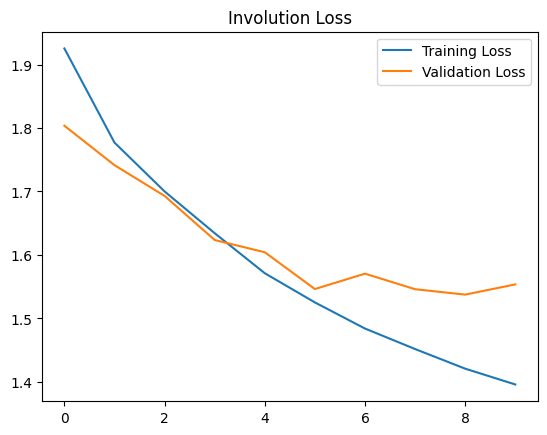

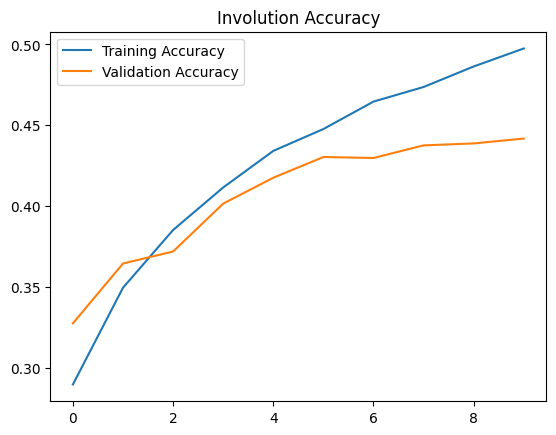

In [112]:

# Eğitim ve doğrulama kaybını görselleştirme
plt.title("Involution Loss")
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()

# Eğitim ve doğrulama doğruluğunu görselleştirme
plt.title("Involution Accuracy")
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.show()

# Bu hücrede, eğitim süresince elde edilen kayıp ve doğruluk değerleri görselleştirilir.


# Referanslar

* https://www.mdpi.com/2072-4292/13/16/3055
* https://keras.io/examples/vision/involution/
* https://arxiv.org/abs/2103.06255v2
